In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2-4*x+5

In [3]:
f(3.0)

20.0

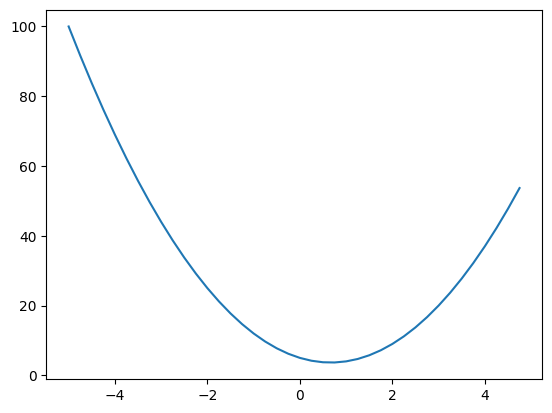

In [4]:
xs = np.arange(-5.0,5.0,0.25)
ys=f(xs)
plt.plot(xs,ys)

### Derivative
In mathematics, the derivative is a fundamental tool that quantifies the sensitivity to change of a function's output with respect to its input.

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3)

In [5]:
h = 0.0001
x = 3.0
(f(x+h)-f(x))/h

14.000300000063248

In [6]:
h = 0.0001

#Input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a+=h
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


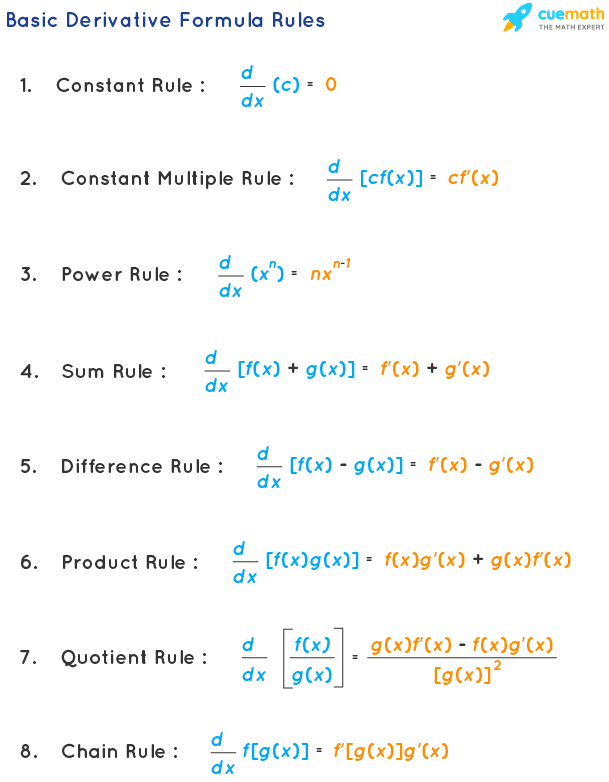

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad= 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance (other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), '+')

        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance (other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance (other, (int, float)), "Only int/float powers are supported"
        out = Value(self.data**other, (self, ), f'{self}**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __rmul__(self, other): # other * self
        return self * other

    def __radd__(self, other): # other + self
        return self + other

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad # t = out.data = o
        out._backward = _backward          
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward= _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo.reverse()

        self.grad = 1.0
        for node in topo:
            node._backward()
     

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [28]:
1+a

Value(data=3.0)

In [ ]:
a+1

Value(data=3.0)

In [74]:
a = Value(2.0)
b = Value(4.0)
a/b

Value(data=0.5)

In [8]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [9]:
L._op


'*'

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


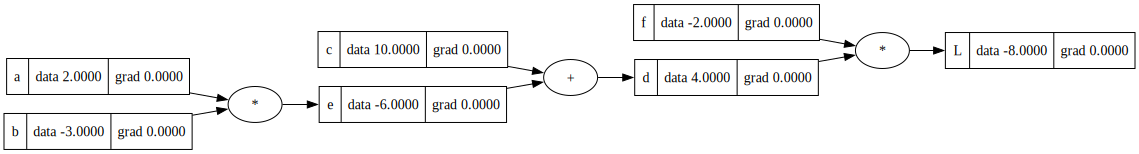

In [11]:
draw_dot(L)

This how impact d to L
<p>
L = d*f
<br>
dL/dd = ?? -> f

#why?
<br>
formula:<br>
f(x) = (f(x+h) - f(x))/h<br>
f(d)
<br>
<p>
sub:<br>
((d+h)*f - d*f)/h 
<br>
(d*f + h*f - d*f )/h <br>
(h*f)/h <br>
f

This how impact c to d
<p>
d = c + e <br>
So, dd/dc = ?? -> 1.0
<p>
#why?<br>
formula:
f(x) = (f(x+h) - f(x))/h<br>
f(d)
<p>
sub:<br>
((c+e)+h - (c+e))/h <br>
(c+e+h-c-e)/h <br>
(h)/h<br>
1.0

<p>
So, (+) will always equal to 1.0<br>
dd/de = ?? -> 1.0

#Chain Rule
----
As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."[1]
<p>

![alt](https://wikimedia.org/api/rest_v1/media/math/render/svg/370629d3d6db86ea972c602a1e96a024ba912389)

Now, we need c to d to L<br>
KNOW: <br>
dL/dd = -2.0 <br>
dd/dc = 1.0<br>
<br>
WANT: <br>
dL/dc = (dL/dd) * (dd/dc) -> -2.0
<br><br>
so, for c.grad = -2.0 as well as e.grad = -2.0


*Next we will apply it all the way to the graph*

KNOW:<br>
dL/de = -2.0
<br><br>
e = a*b<br>
de/da =..? ->b=-3<br>
as well as for de/db will the value of ->a=2.0 <br>
<br><br>
WANT:<br>
dL/da = (dL/de) * (de/da)<br>
dL/db = (dL/de) * (de/db)<br>
so,<br>
a.grad:<br> 
dL/da = -2.0 * -3.0 = 6.0 <br>
b.grad:<br>
dL/db = -2.0 * 2.0 = -4.0 <br>

In [21]:
# Set those manually
L.grad=1.0

f.grad=4.0
d.grad=-2.0

c.grad = -2.0
e.grad = -2.0

a.grad = 6.0
b.grad = -4.0

In [13]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    
    a = Value(2.0, label='a') 
    # a.data+=h
    b = Value(-3.0, label='b')
    b.data+=h
    c = Value(10.0, label='c')
    # c.data+=h
    e = a * b; e.label = 'e'
    # e.data+=h
    d = e + c; d.label = 'd'
    # d.data += h
    f = Value(-2.0, label='f')
    L1 = d * f; L1.label = 'L1'
    
    print((L1.data - L.data) / h)  # Perubahan L dibagi h

lol()

-3.9999999999995595


How about we want to up the value of L.data? <br>
This is basically one step of an optimatization that we'll end up running <br>
and really does gradient just give us some power to influence the final outcome <br>

In [14]:
a.data +=0.01 * a.grad
b.data +=0.01 * b.grad
c.data +=0.01 * c.grad
f.data +=0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


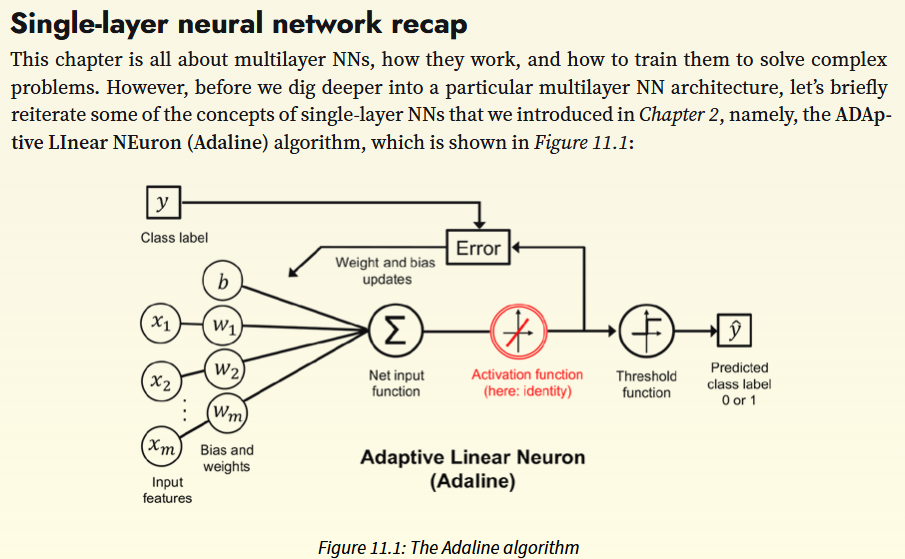

*Acctivation function: Tan H* 

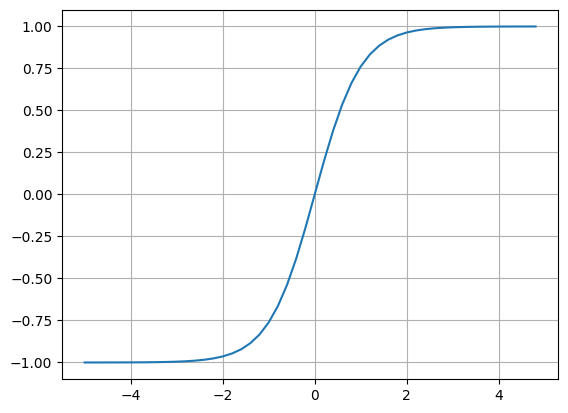

In [15]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid();

*The Tanh activation function is used in neural networks to keep outputs within the range -1 to 1, making learning more stable. Unlike just passing numbers directly, Tanh works like a filter that turns very large positive inputs into values close to +1, very large negative inputs into values close to -1, and small inputs into values around 0. This helps the network focus on important signals while reducing less useful ones.*

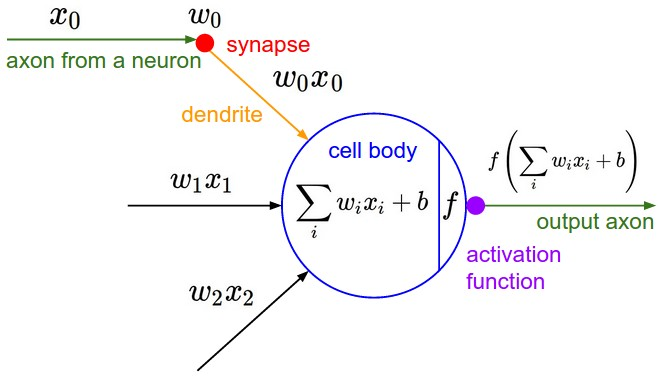

In [59]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2+w2 +b
x1w1 = x1*w1; x1w1.label= 'x1w1'
x2w2 = x2*w2; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label= 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

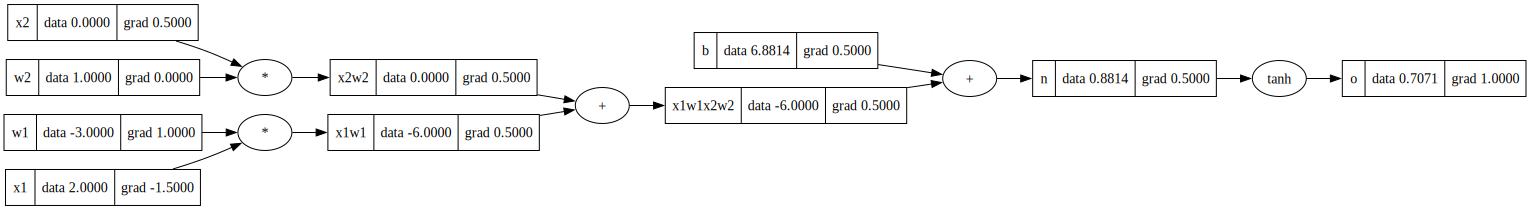

In [62]:
draw_dot(o)

In [61]:
# Final round
o.backward()

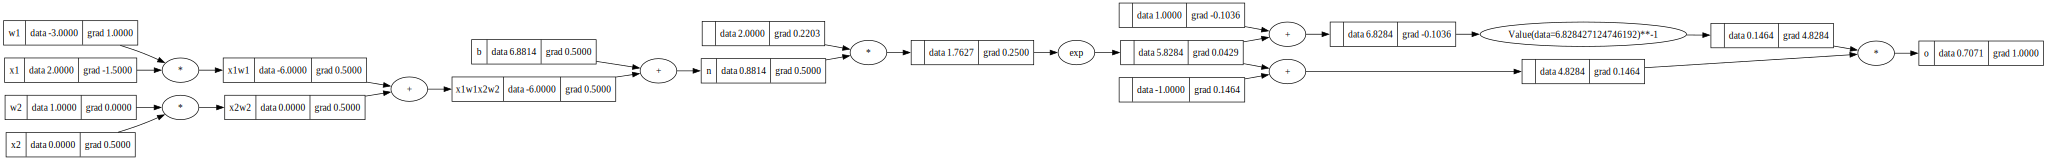

In [77]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2+w2 +b
x1w1 = x1*w1; x1w1.label= 'x1w1'
x2w2 = x2*w2; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label= 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'

o.backward()
draw_dot(o)

<br>So how about we automate this process of backward without set manually the one node each?
<br>
<b>The answer is Topological Sort</b>
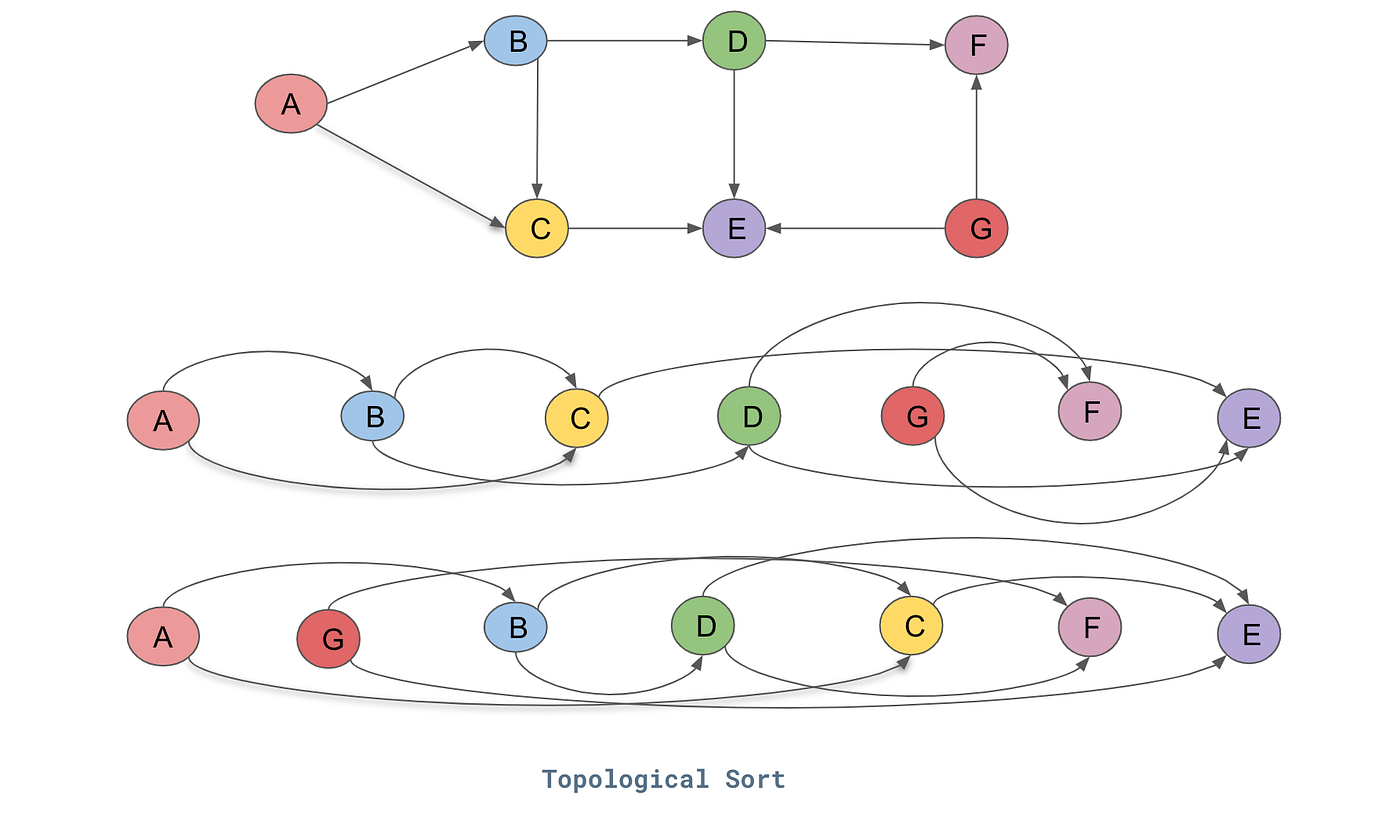
<br>Topological sort is a linear ordering of nodes in a directed acyclic graph (DAG) such that for every directed edge from node A to node B, node A comes before node B in the ordering. In the context of backpropagation in a neural network, this technique is crucial because it ensures that the gradient computation for each node is done only after all the gradients of its dependent nodes (children) have been calculated. 

<br>The image above shows a computational graph with nodes A, B, C, D, E, F, and G, representing operations or variables. The top part is the original graph, while the bottom two parts illustrate possible topological sort orders (A, B, C, D, G, F, E and A, G, B, D, C, F, E). This ordering allows us to propagate gradients backward efficiently:
- Start from the output nodes (e.g., E or F) where the loss gradient is initially known.
- Move backward through the graph, computing the gradient for each node using the gradients of its children, following the topological order.
- This automation ensures no node is processed before its dependencies, avoiding manual setting of gradients and making the process scalable for complex networks.


In [52]:
o.grad = 1.0

In [56]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo.reverse()

for node in topo:
    node._backward()

In [55]:
topo

[Value(data=0.7071067811865476),
 Value(data=0.8813735870195432),
 Value(data=6.881373587019543),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=2.0),
 Value(data=-3.0)]

So next, we put the topology sort function into our class before

<b>Using backward on any one node

In [39]:
o.grad = 1.0

In [ ]:
o._backward()

In [43]:
n._backward()

In [45]:
x1w1x2w2._backward()

In [48]:
x1w1._backward()
x2w2._backward()

In [ ]:
# Manually compute the gradient
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = -1.5
w1.grad = 1.0
x2.grad = 0.5
w2.grad = 0.0 

In [ ]:
1-o.data**2
1-tanh()**2(o.data)

0.4999999999999999

o = tanh(n) <br>
n.grad = derivative of o * out.grad<br>
n.grad = (1 - o^2)*out.grad <br>chain rule<br>

![alt](https://wikimedia.org/api/rest_v1/media/math/render/svg/fbf8ad841d35c189f5b9e2f6d29683555257dbf4)

So,<br>
do/dn= 1-tanh^2(n)<br>
do/dn= 1-tanh(n)*tanh(n)<br>
do/dn= 1-o^2<br>
do/dn = 0.5<br>
<p>for chain rule:</p>
n.grad = 0.5*1.0 = 0.5
<p>
Next, x1w1x2w2 + b = n <br>
Coz, (+) will always equal to 1.0<br> 
dn/db = 1.0<br>
dn/dx1w1x2w2 = 1.0<br>

Now, we need b to n to o<br>
KNOW: <br>
do/dn = 0.5 <br>
dn/db = 1.0<br>
dn/dx1w1x2w2 = 1.0<br>
<br>
WANT: <br>
do/db = (do/dn) * (dn/db) -> 0.5 * 1.0 = 0.5<br>
do/dx1w1x2w2 = (do/dn) * (dn/dx1w1x2w2) -> 0.5 * 1.0 = 0.5<br>
<br><br>
so, for b.grad = 0.5 as well as dx1w1x2w2.grad = 0.5

**The tricky is cause the local of this operation (+) one is constant, and will same as the gradient of the output.**
<p>
Next, x1w1 + x2w2 = x1w1x2w2
<br>
x1w1.grad = 0.5<br>
x2w2.grad = 0.5<br>

<br><br>
Then, x1 + w1 = x1w1<br>
KNOW:<br>
do/dx1w1 = 0.5
<br><br>
x1w1 = x1*w1<br>
dx1w1/dx1 =..? ->w1=-3.0<br>
as well as for dx1w1/dw1 will the value of ->x1=2.0 <br>
<br><br>
WANT:<br>
do/dx1 = (do/dx1w1) * (dx1w1/dx1)<br>
do/dw1 = (do/dx1w1) * (dx1w1/dw1)<br>
so,<br>
x1.grad:<br> 
do/dx1 = 0.5 * -3.0 = -1.5 <br>
w1.grad:<br>
do/dw1 = 0.5 * 2.0 = 1.0 <br>
<br>
As well as, x2 + w2 = x2w2<br>
dx2w2/dx2 = ..? value of w2=1<br>
dx2w2/dw2 = ..? value of x2=0<br>
<br><br>
do/dx2 = (do/dx2w2) * (dx2w2/dx2)<br>
do/dw2 = (do/dx2w2) * (dx2w2/dw2)<br>
so,<br>
x2.grad:<br>
do/dx2 = 0.5 * 1.0 = 0.5<br>
w2.grad:<br>
do/dw2 = 0.5 * 0 = 0<br>
<br>

In [19]:
o.data

0.7071067811865476

In [20]:
1-o.data**2

0.4999999999999999

<i>Oops, we got a problem</i>

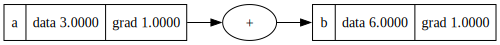

In [63]:
# let say:
a = Value(3.0, label='a')
b  = a + a; b.label='b'
b.backward()
draw_dot(b)

<i>The derivative of b respect to a should be two, it's not one</i>

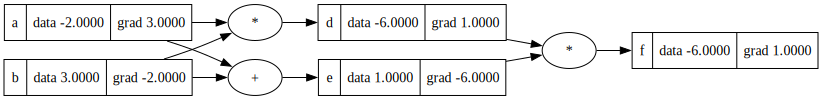

In [65]:
# another problem
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

<b> Chain Rule Guide for Neural Networks</b>

Chain rule is a fundamental calculus rule for computing derivatives of composite functions. Here are the main rules:

<b>1. Basic Chain Rule</b>
If `y = f(g(x))`, then:
```
dy/dx = (dy/df) × (df/dx)
```

<b>2. Multiple Variable Chain Rule</b>
If `z = f(x,y)` and `x = g(t)`, `y = h(t)`, then:
```
dz/dt = (∂z/∂x) × (dx/dt) + (∂z/∂y) × (dy/dt)
```

<b>3. Basic Operations</b>

<b>Addition/Subtraction</b>
```
z = x + y  →  dz/dx = 1, dz/dy = 1
z = x - y  →  dz/dx = 1, dz/dy = -1
```

<b>Multiplication (Product Rule)</b>
```
z = x × y  →  dz/dx = y, dz/dy = x
```

<b>Division (Quotient Rule)</b>
```
z = x/y  →  dz/dx = 1/y, dz/dy = -x/y²
```

<b>Power</b>
```
z = x^n  →  dz/dx = n × x^(n-1)
z = x^y  →  dz/dx = y × x^(y-1), dz/dy = x^y × ln(x)
```

<b>4. Neural Network Activation Functions</b>

<b>Sigmoid</b>
```
σ(x) = 1/(1 + e^(-x))
dσ/dx = σ(x) × (1 - σ(x))
```

<b>Tanh</b>
```
tanh(x) = (e^x - e^(-x))/(e^x + e^(-x))
d(tanh)/dx = 1 - tanh²(x)
```

<b>ReLU</b>
```
ReLU(x) = max(0, x)
dReLU/dx = 1 if x > 0, else 0
```

<b>Softmax</b>
```
softmax_i = e^(x_i) / Σ(e^(x_j))
∂softmax_i/∂x_j = softmax_i × (δ_ij - softmax_j)
```

<b>5. Special Rules for Backpropagation</b>

<b>Gradient Accumulation</b>
When the same variable is used multiple times:
```
z = x + x = 2x  →  dz/dx = 2
z = x × x = x²  →  dz/dx = 2x
```

<b>Fan-out (One Input to Multiple Outputs)</b>
When `x` is used in multiple operations:
```
y1 = f1(x), y2 = f2(x)
dx_total = dy1/dx + dy2/dx
```

<b>6. Matrix/Vector Chain Rule</b>
<br>For matrix operations:
```
Y = X × W  →  dY/dX = W^T, dY/dW = X^T
```

<b>7. Complex Example</b>
```python
# Forward: z = (x + y) × (x - y)
# u = x + y, v = x - y, z = u × v
# Backward:
dz/du = v = (x - y)
dz/dv = u = (x + y)
du/dx = 1, du/dy = 1
dv/dx = 1, dv/dy = -1
# Chain rule:
dz/dx = (dz/du × du/dx) + (dz/dv × dv/dx)
      = (x-y)×1 + (x+y)×1 = 2x

dz/dy = (dz/du × du/dy) + (dz/dv × dv/dy)  
      = (x-y)×1 + (x+y)×(-1) = -2y
```

<b>Your Original Problem</b><br>
In `b = a + a`, the variable `a` is used twice:
- `b = 2a`
- `db/da = 2` (not 1)

_Fix it:_<br>
_We change backward operation from `=` to `+=`, so we accumulation the total of gradient operations instead of just one operation._

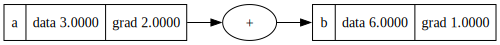

In [ ]:
a = Value(3.0, label='a')
b  = a + a; b.label='b'
b.backward()
draw_dot(b)

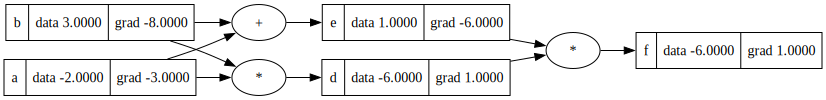

In [69]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

<b>Doing the same thing but in PyTorch</b>

In [4]:
import torch

In [15]:
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 +x2*w2 +b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


<b> Now we build our own neuron</b>

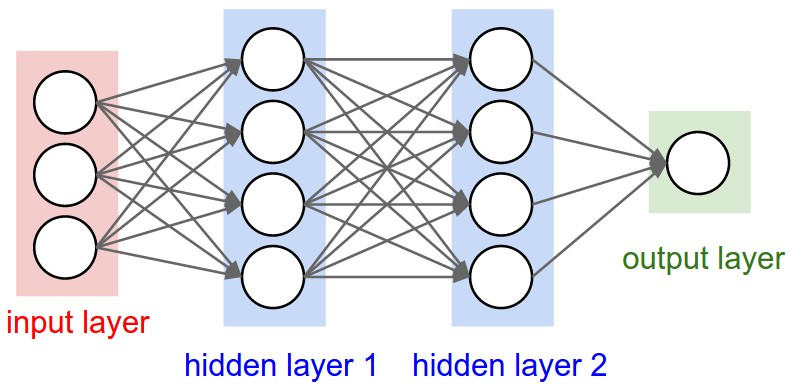

In [28]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        # [3,4,4,1] (input size + layer sizes)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        # Layer 0: Layer(3,4) — from input 3 to hidden1 4 neuron.
        # Layer 1: Layer(4,4) — from hidden1 4 to hidden2 4 neuron.
        # Layer 2: Layer(4,1) — from hidden2 4 to output 1 neuron

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [29]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3734941479624089)

In [103]:
# n.parameters()

In [67]:
# print('So, the total of params in this MLP is', len(n.parameters()))

In [ ]:
# Layer 1 (input 3 → hidden1 4 neuron): 3 × 4 = 12 weight + 4 bias = 16 parameter.
# Layer 2 (hidden1 4 → hidden2 4 neuron): 4 × 4 = 16 weight + 4 bias = 20 parameter.
# Layer 3 (hidden2 4 → output 1 neuron): 4 × 1 = 4 weight + 1 bias = 5 parameter.
# Total: 16 + 20 + 5 = 41

In [30]:
xs = [
    [2.0, 3.0, -1.0],# input 1 
    [3.0, -1.0, 0.5],# and so on..
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

Cause we want to the predict is more close to the true value, so we use the loss function to calculate the loss, and then we use the loss function to calculate the gradient, and then we use the gradient to update the parameters.

In this particular, we will use mean squared error

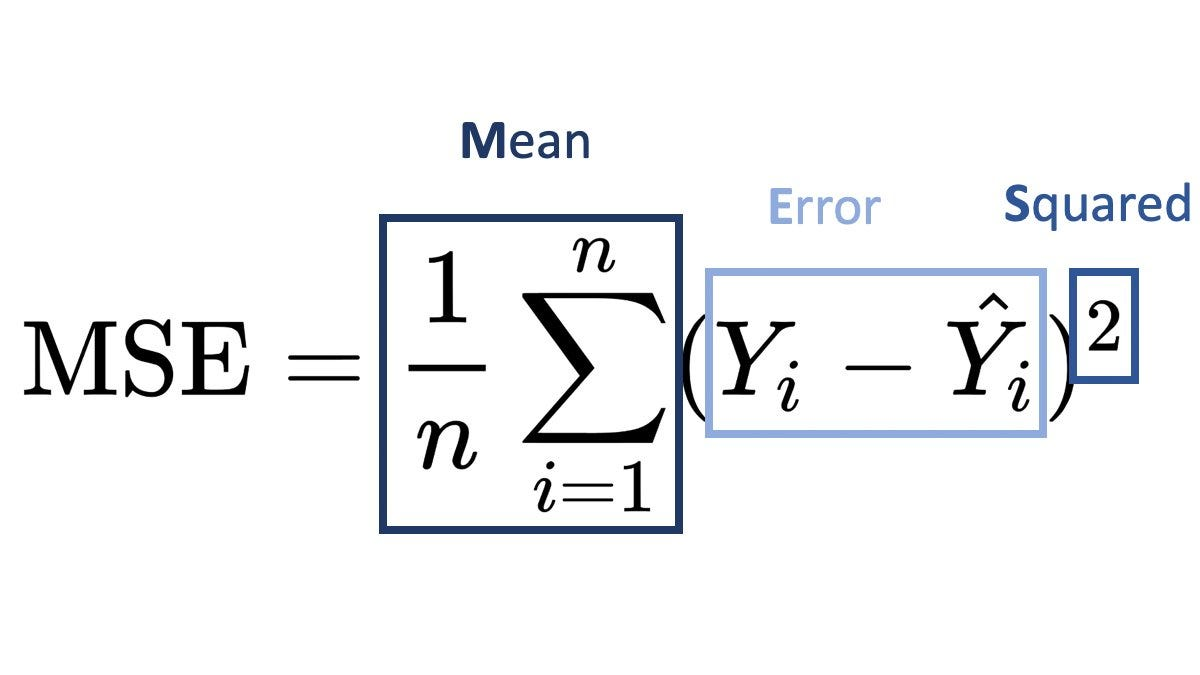

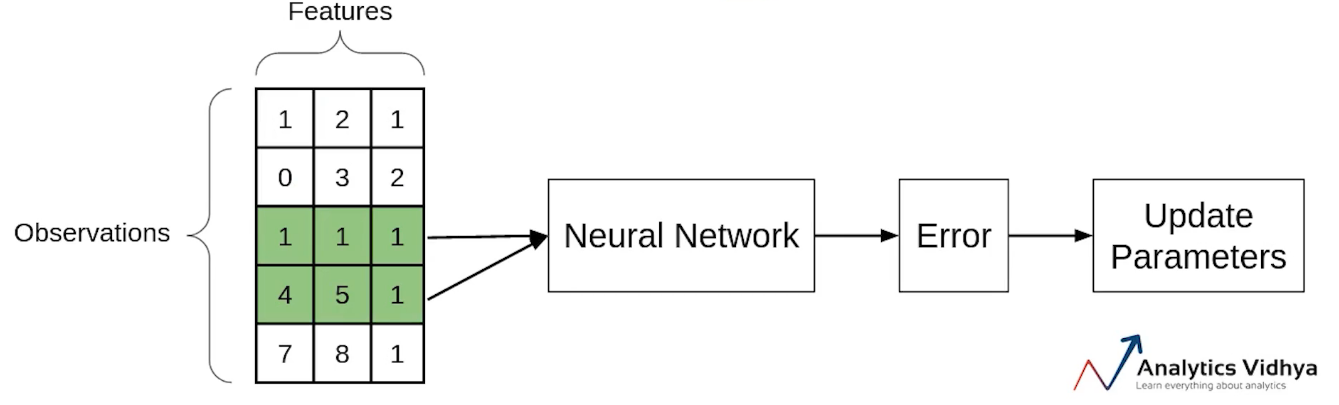

So, we are wanna tiny update for all the parameter to make sure we can reduce the loss, with the optimal parameter. <br>
<i>Simple Gradient Descent

p.new=p.old−η⋅∂L/∂p​ <br> Where η (lr) \> 0

In [ ]:
# This is called gradient descent
for s in range (15):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys, ypred))
    
    #  Backward pass
    for p in n.parameters(): # Zero grad
        p.grad=0.0
    loss.backward()

    # Update parameters
    for p in n.parameters():
        p.data += -0.01 * p.grad

    # Epoch
    print(s, loss.data)

0 0.0934456403723218
1 0.089759734892958
2 0.08632650473241875
3 0.0831231158073653
4 0.08012916393187175
5 0.077326390803238
6 0.07469843431525974
7 0.07223060923507585
8 0.069909714643507
9 0.0677238648999033
10 0.06566234123982195
11 0.06371546144009417
12 0.06187446528678871
13 0.06013141385531346
14 0.05847910085811686


In [38]:
ypred

[Value(data=0.8748889209088918),
 Value(data=-0.8821350994134286),
 Value(data=-0.8484898442559311),
 Value(data=0.9226769331770851)]